# Simulation of flow in fracture network
This notebook presents basic usage of PorePy to set up and solve a flow problem in a mixed-dimensional geometry.

We start out with importing external modules

In [1]:
# Numpy and sparse solvers from scipy is used throughout the code
import numpy as np
import scipy.sparse.linalg as spla
# This is needed to import figures in notebook.
from IPython.display import Image

# Our pracitce is to give porepy the alias pp
import porepy as pp

c:\users\keile\dropbox\workspace\python\ppdir\src\porepy\grids\partition.py:19: UserWarning: Could not import pymetis. Some functions will not work as    intended
  intended"


# Simulation in 2d



## Domain and fracture network specification
A fracture network in a 2d domain is represented by the start and endpoints of individual fractures, and connections between them.
The computational domain is most easily defined as by its bounding box

In [2]:
# Coordinates are always defined as nd x num_points arrays

# Define start and endpoints of the fractures.  
pts = np.array([[0.3, 0.7, 0.8, 0.2],
                [0.2, 0.8, 0.2, 0.8]])
# Connection between the points (that is, the fractures) are specified as a 2 x num_frac array
connections = np.array([[0, 2],
                        [1, 3]])
# Set the domain to the unit square, specified as a dictionary
domain = {'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1}

# Define a 2d fracture network 
network_2d = pp.FractureNetwork2d(pts, connections, domain)

A 2d fracture network can be visualized using matplotlib. Note that the same operation does not apply to 3d fracture networks (to be introduced below); for this we need to turn to Paraview or similar.

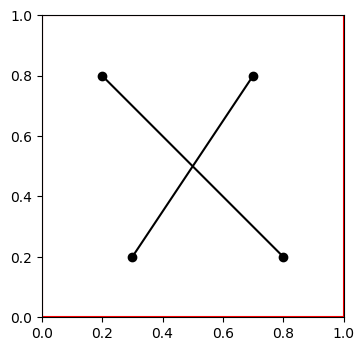

In [3]:
network_2d.plot()

## Meshing
A mixed-dimensional grid, fit for computations, can be constructed using the function FractureNetwork2d.mesh(). The actual mesh is constructed by Gmsh; on the PorePy side, the meshing involves preprocessing of the geometry, attempts at mesh size control, and a fair amount of postprocessing to arrive at the PorePy mesh.

It is critical to set the mesh size parameter: This is controlled by three parameters: The target mesh size on the boundary and fractures, and the minimal 'acceptable' mesh size. The latter is somewhat misleading, as the conneciton between the parameter set, and the values returned by Gmsh is at best corrolated. 

For complex networks, the meshing process requires some experience, and sometimes manual tuning of the grid directly in Gmsh; as a general comment meshing of small details either requires many cells, or leads to bad grids.

In [4]:
# Set a relatively coarse target mesh size on the boundary, attempt some refinement towards the fractures
target_h_bound = 0.3
target_h_fracture = 0.05

# The mesh size parameters must be packaged inside a dictionary
mesh_args = {'mesh_size_bound': target_h_bound, 'mesh_size_frac': target_h_fracture}

# Construct the mesh to obtain a mixed-dimensional PorePy mesh
gb = network_2d.mesh(mesh_args)

## Mixed-dimensional grids
The mixed-dimensional mesh is represented by a GridBucket class (thus mesh objects are commonly denoted gb in the code). The GridBucket is a collection of fixed-dimensional (i.e. of one dimension, but not necessarily 1d) grids, together with tools to map between the grids etc.

We first inpect the GridBucket just constructed

In [5]:
print(gb)

Mixed dimensional grid. 
Maximum dimension 2
Minimum dimension 0
Size of highest dimensional grid: Cells: 316. Nodes: 200
In lower dimensions: 
2 grids of dimension 1
1 grids of dimension 0



Observe that the GridBucket has one grid of dimension 2, 2 1d grids (one per fracture). Moreover, a 0d grid is introduced in the fracture intersection.

We can also visualize the mesh: Again, rudimentary plotting is available in 2d

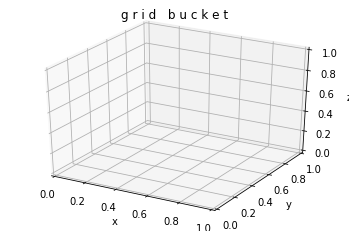

In [6]:
pp.plot_grid(gb)

We clearly see the result of the mesh refinement towards the fracture.

For more visually appealing plots, export to Paraview (really, vtu-format) is available:

In [7]:
exporter = pp.Exporter(gb, name='grid_illustration_2d')
exporter.write_vtk()

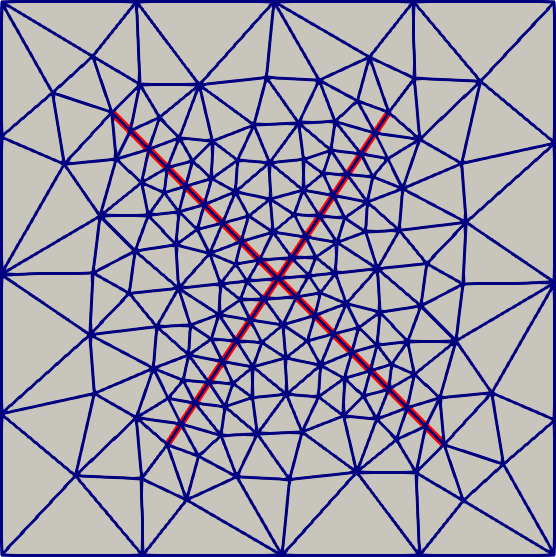

In [8]:
Image("img/grid_ill_2d.png")

For manipulation in Paraview, it is useful to note that the fixed-dimensional grids are represented as different objects, and that they have a property grid_dim, which can be used to filter out grids of unwanted dimensions.

We can also pick out an individual grid, and access its information (see also the tutorial grid_structure.ipynb)

In [9]:
# Pick out the grids of dimension 1 (as a list), then pick the first one
g_1d = gb.grids_of_dimension(1)[0]

# now, we can access face coordinates by
# g_1d.face_centers



Finally, the interfaces between subdomains are referred to as edges internally to the GridBucket. We will see them in action below.

## Define a flow problem

Next define a flow problem on the mixed-dimensional geometry. First, denote by $\Omega_i$ a subdomain which is tessalated by a grid in the GridBucket. In this case, there are four subdomains (1 in 2d, 2 in 1d, and 1 in 0d).

On the subdomains of dimension 1 or more, flow is governed by Darcy's law:

$$\nabla \cdot \mathbf{u}_i = f_i - \sum_{j \in \hat{S}_i} \Xi_j^i\lambda_j \qquad \mathbf{u}_i = - K_i \nabla p_i$$

Where $\mathbf{u}_i$ is the Darcy velocity, $p_i$ is the fluid pressure, $K_i$ is the permeability, $f_i$ source terms, and the summation on the right hand side of the conservation equation represents inflow from higher-dimensional subdomains. The projection $\Xi_j^i$ transfers the flux (more generally, extensive quantities) from object $j$ (in this case an interface) to $i$ (here a subdomain).

Influx from lower-dimensional is given as Neumann boundary conditions,

$$\mathbf{u}_i \cdot \mathbf{n}_j = \Xi_j^i \lambda_j,   \forall j \in \check{S}_i$$

The interface flux between subdomains is governed by a Darcy-type law

$$ \lambda_j = \kappa_j (\Pi_h^j tr p_h - \Pi_l^j p_l)$$

Here subscripts $h$ and $l$ represent the higher- and lower-dimensional neighboring subdomain, while $\Pi_l^j$ is the projection of the flux (generally intensive quantities) from object $l$ to interface $j$. The coefficient $\kappa_j$ is referred to as the normal diffusivity of the interface; this can be interpreted as the effective permeability normal to the fracture plane.

Finally, we set Dirichlet boundary conditions on the bottom and top boundaries, and homogeneous Neumann conditions on the :
    $$p = 1\, \mathrm{on}\, y=0, \qquad p = 0\, \mathrm{on}\, y=1, \qquad \mathbf{u}\cdot\mathbf{n} = 0\, \mathrm{on}\, x=\{0, 1\}$$
    
We note that in this case only the 2d domain sees the global boundary.    
  




## Parameter assignment
PorePy needs various parameters to solve a certain problem - the parameters needed naturally depend on the problem at hand. For some classe of problems (those most used by the developers), a set with what is deemed default parameters can be initialized with relative ease.

In [10]:
# This keyword is used to define which set of default parameters to pick
# If you want to a setup which targets transport or mechanics problem,
# rather use the keyword 'transport' or 'mechanics'.
# For other usage, you will need to populate the parameter dictionary manually.
parameter_keyword = 'flow' 

# Maximum dimension of grids represented in the grid bucket
max_dim = gb.dim_max()

# Loop over all grids in the GridBucket. 
# The loop will return a grid, and a dictionary used to store various data
for g, d in gb:

    # Permeability assignment
    # Differentiate between the rock matrix and the fractures.
    if g.dim == max_dim:
        kxx = np.ones(g.num_cells)
    else:  # g.dim == 1 or 0; note however that the permeability is not used in 0d domains
        kxx = 0.1 * np.ones(g.num_cells)

    perm = pp.SecondOrderTensor(gb.dim_max(), kxx)

    # Create a dictionary to override the default parameters.
    # NB: The permeability is associated wiht the keyword second_order_tensor.
    specified_parameters = {'second_order_tensor': perm}
    
    # Add boundary conditions for 2d problems
    if g.dim == max_dim:
        # Dirichlet conditions on top and bottom
        # Note that the y-coordinates of the face centers are stored in the 
        # second row (0-offset) of g.face_centers
        top = np.where(np.abs(g.face_centers[1] - 1) < 1e-5)[0]
        bottom = np.where(np.abs(g.face_centers[1]) < 1e-5)[0]
        
        # On the left and right boundaries, we set homogeneous Neumann conditions
        # Neumann conditions are set by default, so there is no need to do anything
        
        # Define BoundaryCondition object
        bc_faces = np.hstack((top, bottom))
        bc_type = bc_faces.size * ['dir']
        bc = pp.BoundaryCondition(g, faces=bc_faces, cond=bc_type)
        
        # Register the assigned value
        specified_parameters['bc'] = bc
        
        # Alse set the values - specified as vector of size g.num_faces
        bc_values = np.zeros(g.num_faces)
        bc_values[top] = 0
        bc_values[bottom] = 1
        specified_parameters['bc_values'] = bc_values
        
    # On 1d and 0d problems we set no boundary condition - in effect assigning Neumann conditions

    # Assign the values to the data dictionary d.
    # By using the method initialize_default_data, various other fields are also
    # added, see 
    pp.initialize_default_data(g, d, parameter_keyword, specified_parameters)

    # Internally to the Parameter class, the parameters are stored as dictionaries.
    # To illustrate how to access specific sets of parameters, print the keywords
    # for one of the grids.
    # Note the nested dictionaries.
    if g.dim == max_dim:
        print('The assigned parameters for the 2d grid are')
        print(d[pp.PARAMETERS][parameter_keyword].keys())

# Next loop over the edges (interfaces) in the         
for e, d in gb.edges():
    # On edges in the GridBucket, there is currently no methods for default initialization.

    # Set the normal diffusivity parameter (the permeability-like transfer coefficient)
    data = {"normal_diffusivity": 2e1}

    # Add parameters: We again use keywords to identify sets of parameters.
    # 
    mg = d["mortar_grid"]
    pp.initialize_data(mg, d, parameter_keyword, data)
    


The assigned parameters for the 2d grid are
dict_keys(['aperture', 'porosity', 'source', 'mass_weight', 'second_order_tensor', 'bc', 'bc_values', 'time_step'])


Observe that the 

## Assign variables and discretizations
We need to assign discretizations on every subdomain, and on every interface between the subdomains. Moreover, it is necessary to specify the name and type of variable on all subdomains and interfaces.

This assignment can be a bit cumbersome in PorePy - simple usage has been sacrificed somewhat to gain flexibility for multi-phyiscs problems. 

In [11]:
# We will use a multi-point flux approximation method on all subdomains
# Note that we need to provide the same keyword that we used when setting the parameters on the subdomain.
# If we change to pp.Mpfa(keyword='foo'), the discretization will not get access to the parameters it needs
subdomain_discretization = pp.Mpfa(keyword=parameter_keyword)

# On all subdomains, variables are identified by a string.
# This need not be the same on all subdomains, even if the governing equations are the same,
# but here we go for the simple option.
subdomain_variable = 'pressure'

# Identifier of the discretization operator for each term.
# In this case, this is seemingly too complex, but for, say, an advection-diffusion problem
# we would need two discretizaiton objects (advection, diffusion) and one keyword
# per operator
subdomain_operator_keyword = 'diffusion'

# Specify discertization objects on the interfaces / edges
# Again give the parameter keyword, and also the discretizations used on the two neighboring
# subdomains (this is needed to discretize the coupling terms)
edge_discretization = pp.RobinCoupling(parameter_keyword, subdomain_discretization, subdomain_discretization)
# Variable name for the interface variable
edge_variable = 'interface_flux'
# ... and we need a name for the discretization opertaor for each coupling term
coupling_operator_keyword = 'interface_diffusion'



# Loop over all subdomains in the GridBucket, assign parameters
# Note that the data is stored in sub-dictionaries
for g, d in gb:
    # Assign primary variables on this grid, compatible with the designated discretization scheme
    # In this case, the discretization has one degree of freedom per cell.
    # If we changed to a mixed finite element method, this could be {'cells': 1, "faces": 1}
    d[pp.PRIMARY_VARIABLES] = {subdomain_variable: {"cells": 1, "faces": 0}}
    # Assign discretization operator for the variable.
    # If the discretization is composed of several terms, they can be assigned
    # by multiple entries in the inner dictionary, e.g.
    #  {operator_keyword_1: method_1, operator_keyword_2: method_2, ...}
    d[pp.DISCRETIZATION] = {subdomain_variable: {subdomain_operator_keyword: subdomain_discretization}}    

# Next, loop over the edges
for e, d in gb.edges():
    # Get the grids of the neighboring subdomains
    # The first will always be the lower-dimensional
    g1, g2 = gb.nodes_of_edge(e)
    # The interface variable has one degree of freedom per cell in the mortar grid
    # This is essentially a DG(0) discretization
    d[pp.PRIMARY_VARIABLES] = {edge_variable: {"cells": 1}}
    
    # The coupling discretization links an edge discretization with variables
    # and discretization operators on each neighboring grid
    d[pp.COUPLING_DISCRETIZATION] = {
        # This assignment associate this coupling term with a unique combination of variable 
        # and term (thus discretization object) applied to each of the neighboring subdomains.
        # Again, the complexity is not warranted for this problem, but necessary for general
        # multi-physics problems with non-trivial couplings between variables.
        coupling_operator_keyword: {
            g1: (subdomain_variable, subdomain_operator_keyword),
            g2: (subdomain_variable, subdomain_operator_keyword),
            e: (edge_variable, edge_discretization),
        }
    }

## Assembly and solve
Finally, we can assemble and solve the full problem. Assembly is done by the Assembler class, which is essentially a degree of freedom manager.


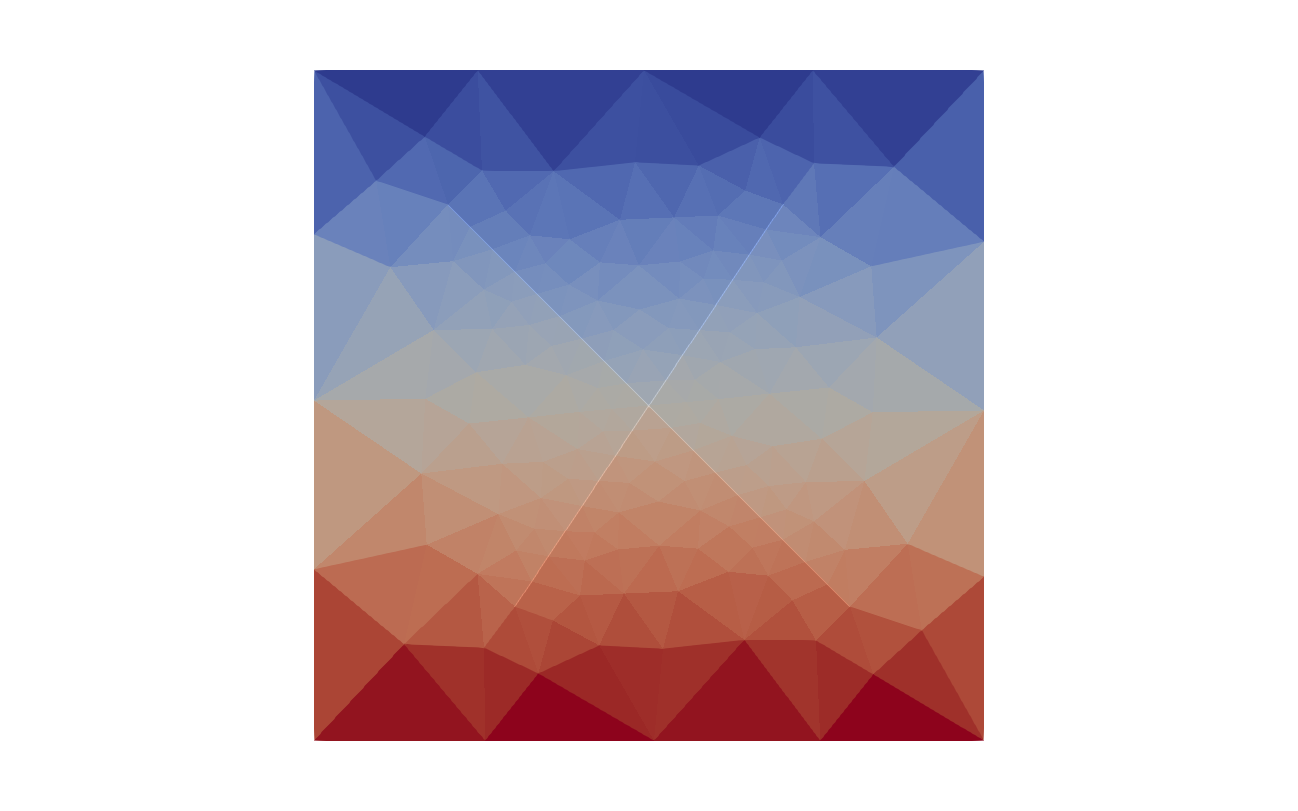

In [12]:
# Initialize the assembler with the GridBucket it should operate on.
# Initialization will process the variables defined above (name, number, and number of dofs)
# and assign global degrees of freedom.
assembler = pp.Assembler(gb)

# First discretize. This will call all discretizaiton operations defined above
assembler.discretize()

# Finally, assemble matrix and right hand side
A, b = assembler.assemble_matrix_rhs()

# Direct solver
sol = spla.spsolve(A, b)

# The solution vector is a global vector. Distribute it to the local grids and interfaces
assembler.distribute_variable(sol)

# Write to vtk. This will overwrite the pure grid file set above.
# Note that we only export the subdomain variable, not the one on the edge
exporter.write_vtk(subdomain_variable)

Image("img/pressure_profile_2d.png")

In [13]:
# We can also get the solution for a specific variable on a specific subdomain from the assembler.
# Pick out the second 1-d grid
g_1d = gb.grids_of_dimension(1)[1]
sub_sol = sol[assembler.dof_ind(g_1d, subdomain_variable)]

# To access the information from the data structure:
# Data dictionary of the grid
d = gb.node_props(g_1d)
# The solution is stored in a sub-dictionary
p = d[pp.STATE][subdomain_variable]

# This should give zeros only.
print(sub_sol - p)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Excercises

1. Make the fractures blocking by manipulating the normal diffusivity. Visualize the effect.
2. Change the subdomain discretization in the 2d grid to lowest-order Raviat-Thomas (pp.RT0). 
3. Refine the grid near the fractures, and in the far-field.
4. Add a third fracture, with end points $(0.2, 0), (0.2, 1)$